In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn as sk

# Cargar el archivo CSV en un DataFrame
file_path = './Data/avocado.csv'
avocado = pd.read_csv(file_path)
avocado.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


## Actividades de Análisis

### 1. **Análisis de Series Temporales**
**Resumen:** El análisis de series temporales permite identificar patrones, tendencias y estacionalidades en los precios y volúmenes de ventas de aguacates a lo largo del tiempo.

1. **Descomposición de Series Temporales de Precios:** 
   - **Uso de Datos:** Usa la columna `AveragePrice` y `Date`.
   - **Esperado:** Utiliza la función `seasonal_decompose` de la librería `statsmodels` para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido. 
     - Convierte `Date` a tipo datetime usando `pd.to_datetime()`.
     - Agrupa los datos por `Date` y calcula el promedio de `AveragePrice` utilizando `groupby()` si es necesario.
     - Visualiza los componentes descompuestos usando `matplotlib` para cada uno de ellos.

Media de precio mensual de aguacates:  1.405978409775878


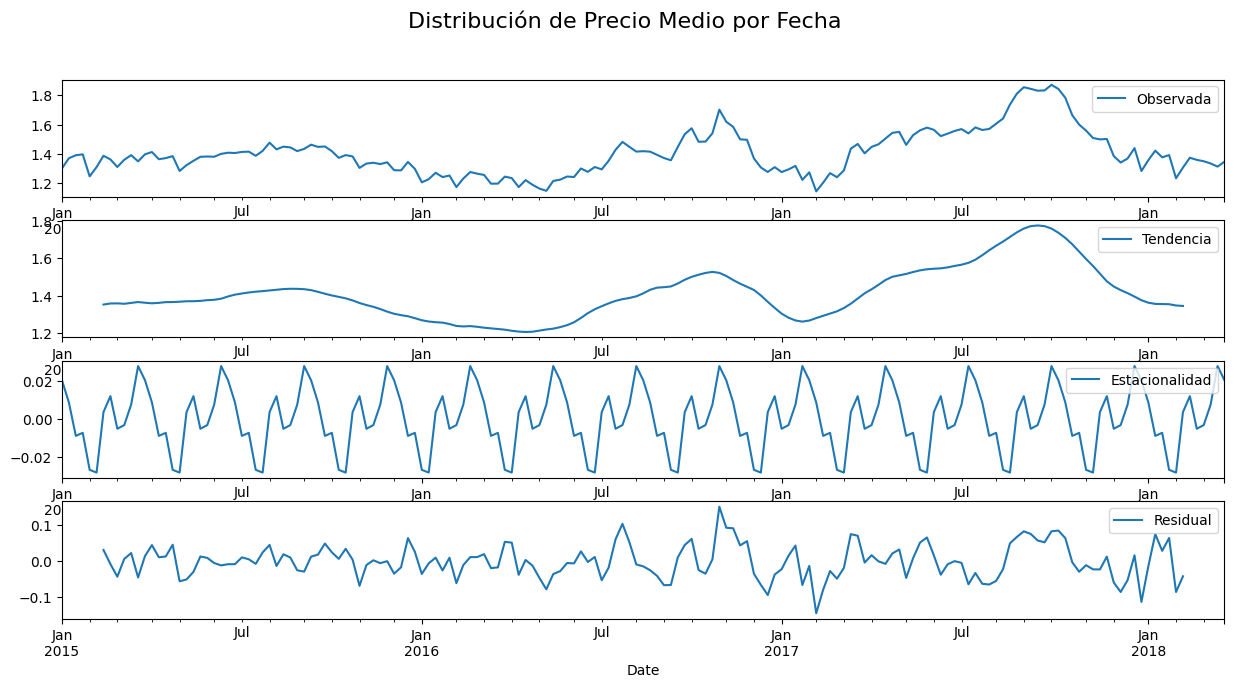

In [15]:
# Formatear fecha en DateTime
avocado["Date"] = pd.to_datetime(avocado["Date"])

# Agrupa los datos por `Date` y calcula el promedio de `AveragePrice` utilizando `groupby()` si es necesario.

monthly_mean = avocado.groupby(avocado.Date)["AveragePrice"].mean()

# Visualiza los componentes descompuestos usando `matplotlib` para cada uno de ellos.

global_mean = avocado[["AveragePrice"]].mean().iloc[0]
print("Media de precio mensual de aguacates: ",global_mean)

decompose = sm.tsa.seasonal_decompose(monthly_mean, model="additive", period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 7))

fig.suptitle('Distribución de Precio Medio por Fecha', fontsize=16)
decompose.observed.plot(ax=axes[0], legend=True, label="Observada")
decompose.trend.plot(ax=axes[1 ], legend=True, label="Tendencia")
decompose.seasonal.plot(ax=axes[2], legend=True, label="Estacionalidad")
decompose.resid.plot(ax=axes[3], legend=True, label="Residual")

plt.show()

2. **Análisis de Estacionalidad por Región:** 
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Date` y `Total Volume`.
   - **Esperado:** Utiliza gráficos de líneas para visualizar cómo varían los precios de aguacates por región a lo largo de diferentes estaciones del año.
     - Agrupa los datos por `region` y `Date` utilizando `groupby()`.
     - Calcula el promedio de `AveragePrice` para cada región.
     - Representa gráficamente las tendencias utilizando `plt.plot()` de `matplotlib`.

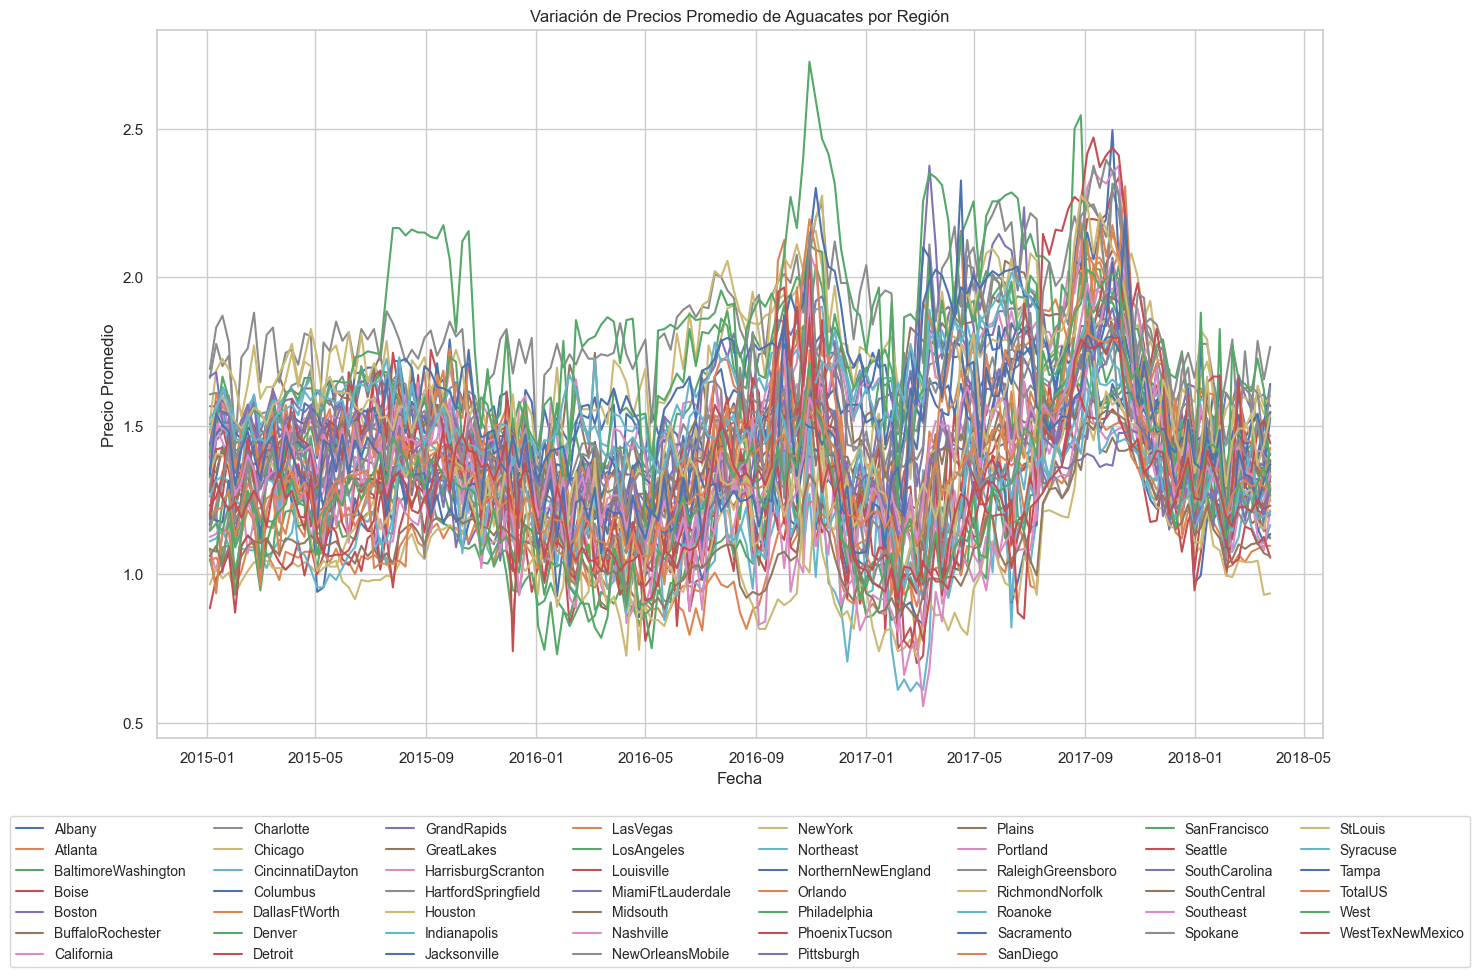

In [56]:
# Convierte la columna 'Date' a formato fecha
avocado['Date'] = pd.to_datetime(avocado['Date'])

# Convierte la columna 'AveragePrice' a numérico para evitar errores en la media. 
# Si hay un valor inválido en la conversion (con el argumento coerce) se pasa a NaN
avocado['AveragePrice'] = pd.to_numeric(avocado['AveragePrice'], errors='coerce')

# Elimina filas con NaN en 'AveragePrice'
avocado.dropna(subset=['AveragePrice'], inplace=True)

avocado_filtered = avocado[['region', 'Date', 'AveragePrice']]

# Se agrupa los datos por 'region' y 'Date' y calcula el promedio de 'AveragePrice'
regional_price = avocado_filtered.groupby(['region', 'Date']).mean().reset_index()

# Lista de las regiones
regions = avocado['region'].unique()

# Gráficos de línea para cada región
plt.figure(figsize=(15, 10))
for region in regions:
    # Filtra los datos para cada región
    data = regional_price[regional_price['region'] == region]
    
    # Gráfico de la tendencia de precios promedio durante las estaciones del año
    plt.plot(data['Date'], data['AveragePrice'], label=region)

plt.title('Variación de Precios Promedio de Aguacates por Región')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=8, fontsize='small')
plt.show()

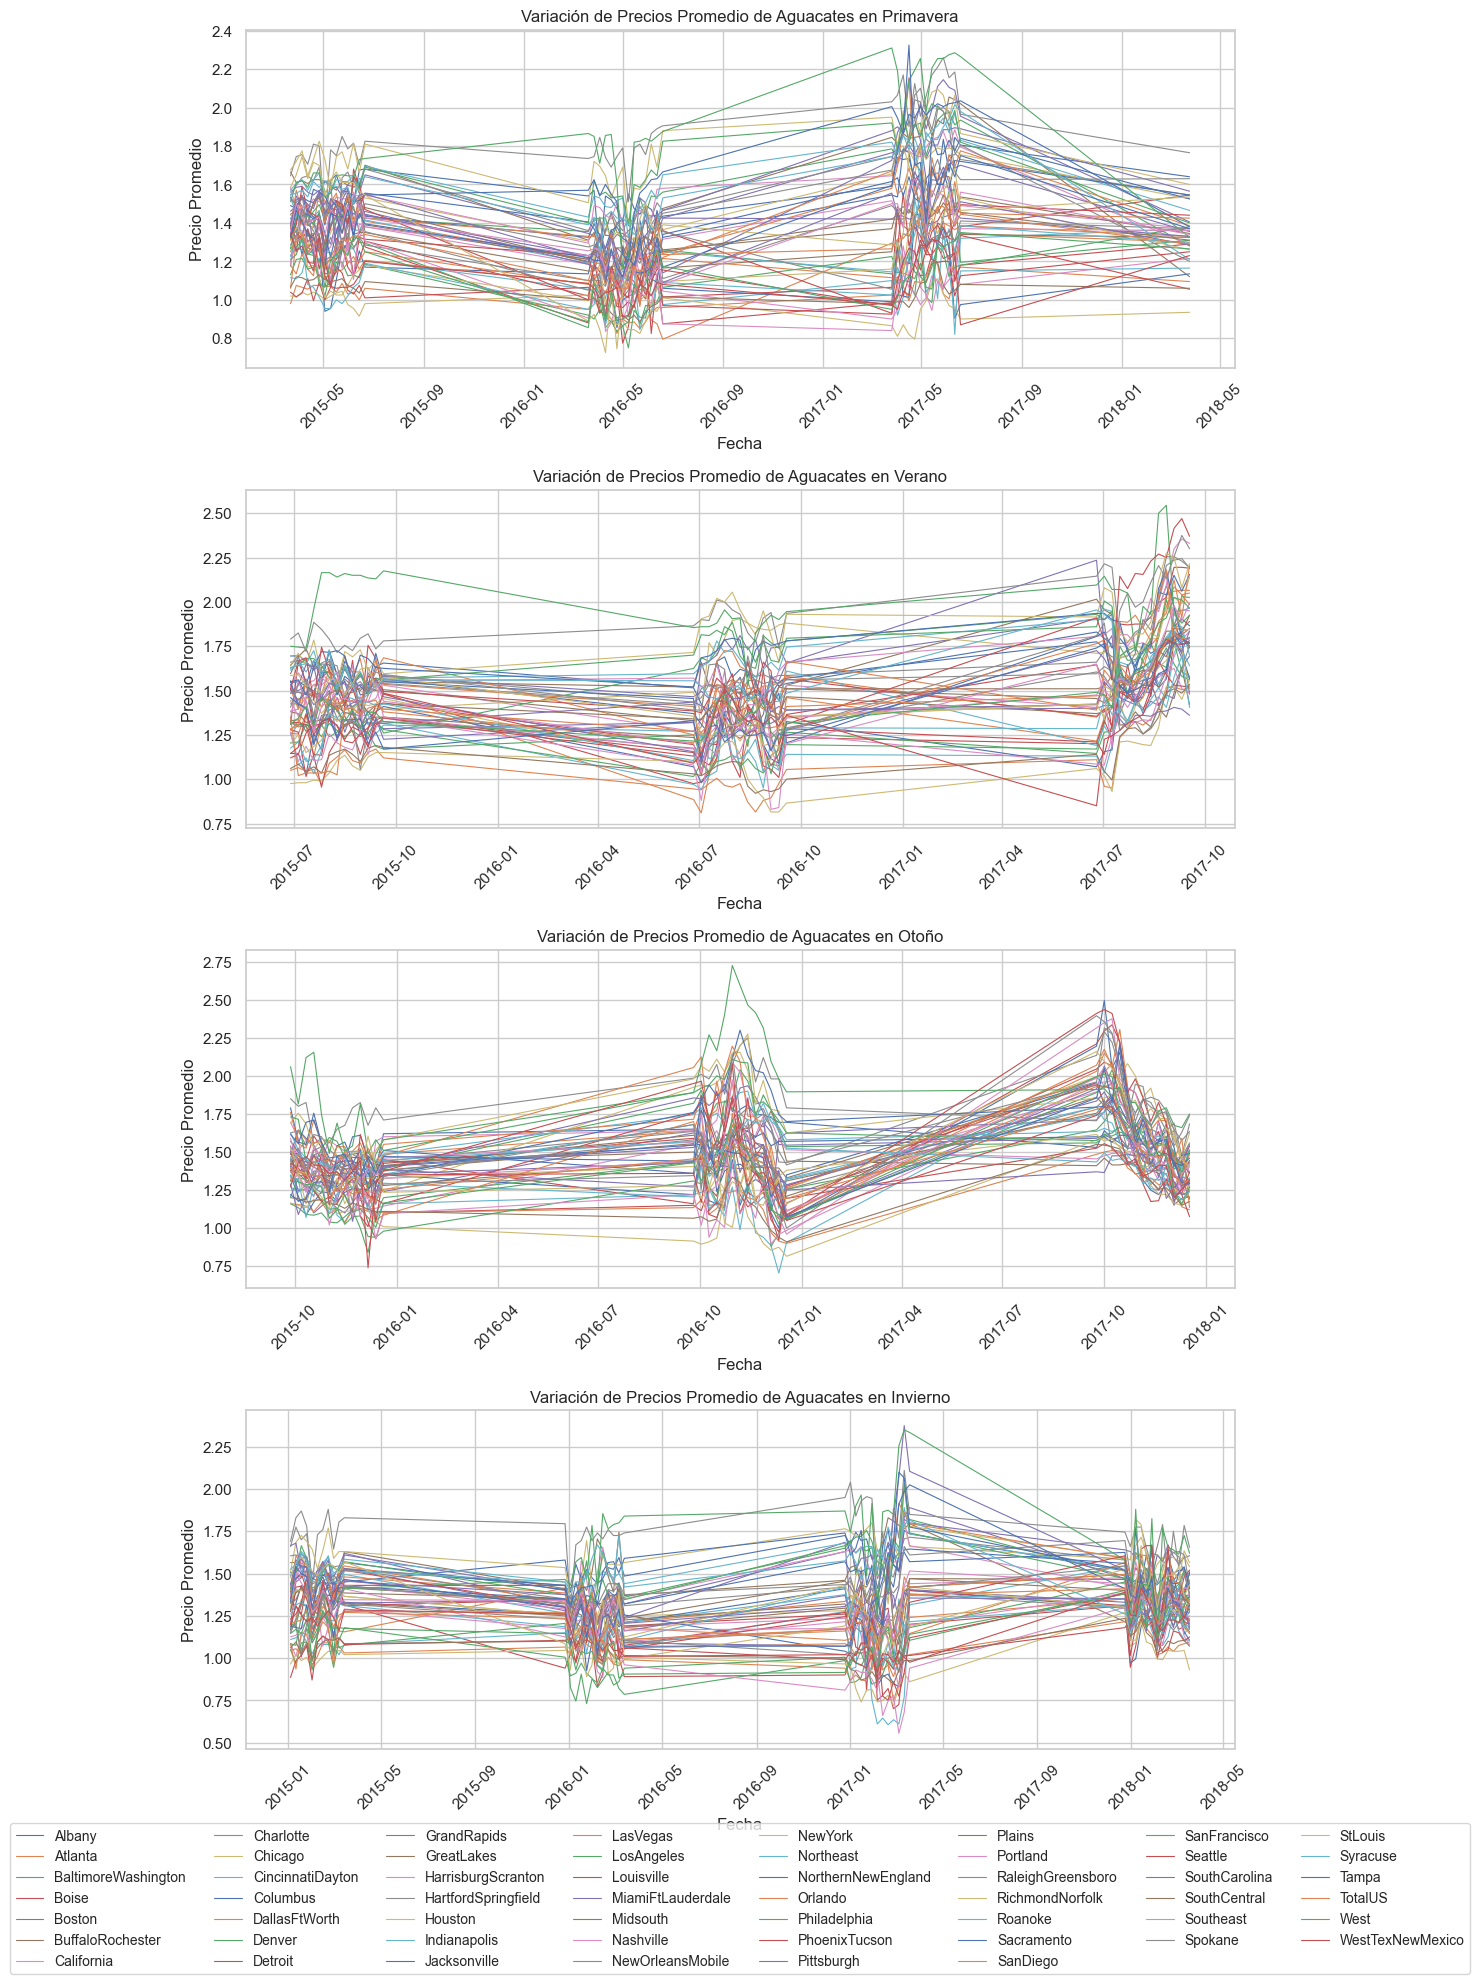

In [59]:
avocado['Date'] = pd.to_datetime(avocado['Date'])

# Calculamos el promedio de `AveragePrice` y el volumen total `Total Volume` por región y fecha
avocado_grouped = avocado.groupby(['region', 'Date']).agg({'AveragePrice': 'mean', 'Total Volume': 'sum'}).reset_index()

# Definimos los límites de las estaciones
seasons = {
    'Primavera': ((3, 20), (6, 21)),
    'Verano': ((6, 21), (9, 22)),
    'Otoño': ((9, 22), (12, 21)),
    'Invierno': ((12, 21), (3, 20))
}

# La función determina la estación de acuerdo a la fecha
def get_season(date):
    month = date.month
    day = date.day
    for season, ((start_month, start_day), (end_month, end_day)) in seasons.items():
        if (month == start_month and day >= start_day) or (month == end_month and day <= end_day) or \
           (start_month < month < end_month) or \
           (start_month > end_month and (month > start_month or month < end_month)):
            return season
    return None

# Añadimos una columna 'Season' en el DataFrame agrupado
avocado_grouped['Season'] = avocado_grouped['Date'].apply(get_season)

# Graficamos los precios promedio por región en cada estación
plt.figure(figsize=(14, 20))

for i, season in enumerate(seasons.keys(), 1):
    season_data = avocado_grouped[avocado_grouped['Season'] == season]
    plt.subplot(4, 1, i)
    for region, data in season_data.groupby('region'):
        plt.plot(data['Date'], data['AveragePrice'], label=region, linewidth=0.8)
    plt.title(f"Variación de Precios Promedio de Aguacates en {season}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio Promedio")
    plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize='small', ncol=8)

plt.tight_layout()
plt.show()

3. **Comparación de Precios Promedio Mensuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Date`.
   - **Esperado:** Calcula y compara los precios promedio mensuales.
     - Agrupa los datos por mes usando `pd.Grouper` con `freq='M'`.
     - Calcula el promedio de `AveragePrice` para cada mes con `mean()`.
     - Visualiza los resultados con un gráfico de líneas usando `plt.plot()`.

4. **Tendencia de Ventas a lo Largo del Tiempo:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `Date`.
   - **Esperado:** Analiza cómo varía el volumen total de ventas a lo largo del tiempo.
     - Agrupa los datos por `Date` y suma el `Total Volume` usando `groupby()`.
     - Visualiza los resultados usando un gráfico de líneas con `plt.plot()` para mostrar la tendencia.

5. **Análisis de Cambios en Precios Anuales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `year`.
   - **Esperado:** Observa las diferencias anuales en los precios promedio.
     - Agrupa los datos por `year` utilizando `groupby()`.
     - Calcula el promedio de `AveragePrice` para cada año.
     - Representa los resultados en un gráfico de barras usando `plt.bar()` que compare los precios de cada año.


### 2. **Gráficos para Visualización de Datos**
**Resumen:** La visualización de datos es clave para identificar patrones y relaciones entre diferentes variables. Los gráficos apropiados pueden proporcionar información valiosa sobre el comportamiento de los precios y volúmenes de ventas.

1. **Gráfico de Violín de Volumen de Ventas por Región:**
   - **Uso de Datos:** Usa las columnas `Total Volume` y `region`.
   - **Esperado:** Visualiza la distribución de ventas en diferentes regiones.
     - Utiliza la función `violinplot` de `seaborn` para crear gráficos de violín.
     - Configura los ejes para mostrar la relación entre `Total Volume` y `region`.
     - Añade etiquetas y títulos usando `plt.title()` y `plt.xlabel()` para facilitar la interpretación.

2. **Boxplot Comparativo de Precios entre Años:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `year`.
   - **Esperado:** Genera boxplots para comparar la distribución de precios.
     - Utiliza `boxplot` de `seaborn` para crear boxplots que comparen `AveragePrice` entre diferentes años.
     - Asegúrate de que cada boxplot represente un año diferente.
     - Incluye etiquetas y títulos descriptivos usando `plt.title()`.

Text(0, 0.5, 'Precio Promedio')

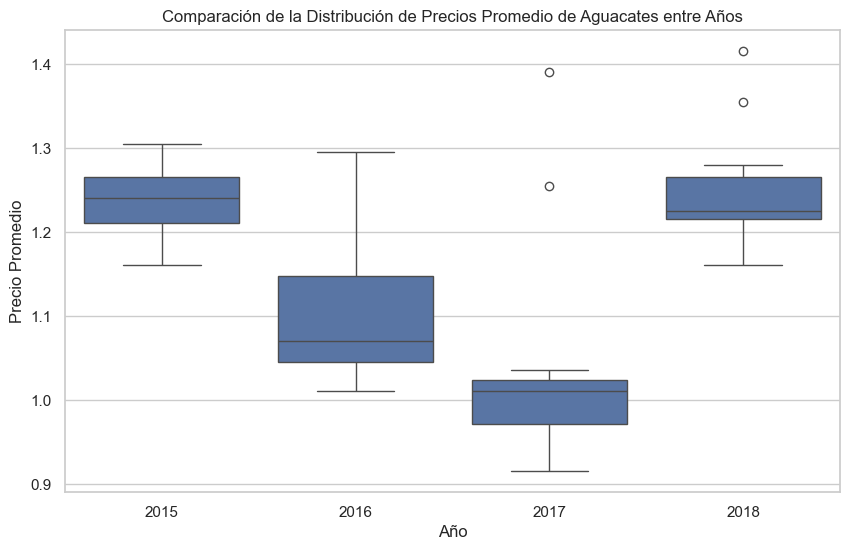

In [62]:
#codigo
# Indico el tamaño del grafico
plt.figure(figsize=(10, 6))

# Boxplot de precios promedio por año
sns.boxplot(x='year', y='AveragePrice', data=data)

plt.title('Comparación de la Distribución de Precios Promedio de Aguacates entre Años')
plt.xlabel('Año')
plt.ylabel('Precio Promedio')

3. **Histograma de Volumen Total de Ventas:**
   - **Uso de Datos:** Usa la columna `Total Volume`.
   - **Esperado:** Crea un histograma para mostrar la distribución del volumen total de ventas.
     - Utiliza `hist()` de `matplotlib` para crear el histograma.
     - Ajusta el número de bins para una visualización clara usando el parámetro `bins`.
     - Añade etiquetas y un título que describa lo que se muestra.

4. **Gráfico de Barras de Ventas por Tipo de Bolsa:**
   - **Uso de Datos:** Utiliza las columnas `Total Bags`, `Small Bags`, `Large Bags` y `XLarge Bags`.
   - **Esperado:** Compara las ventas de diferentes tipos de bolsas.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `sum()`.
     - Crea un gráfico de barras con `plt.bar()` para mostrar las diferencias en ventas.
     - Asegúrate de incluir etiquetas para cada tipo de bolsa.

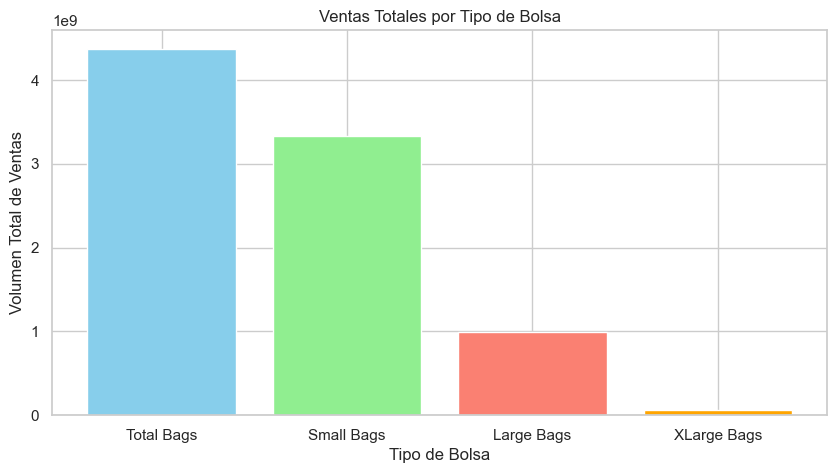

In [74]:
#codigo

total_bags = avocado['Total Bags'].sum()
small_bags = avocado['Small Bags'].sum()
large_bags = avocado['Large Bags'].sum()
xlarge_bags = avocado['XLarge Bags'].sum()

# Crear gráfico de barras
bag_types = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
bag_sums = [total_bags, small_bags, large_bags, xlarge_bags]

plt.figure(figsize=(10, 5))
plt.bar(bag_types, bag_sums, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title('Ventas Totales por Tipo de Bolsa')
plt.xlabel('Tipo de Bolsa')
plt.ylabel('Volumen Total de Ventas')
plt.show()

5. **Gráfico de Líneas de Precios Promedios por Año:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice` y `year`.
   - **Esperado:** Visualiza la tendencia de precios promedio a lo largo de los años.
     - Agrupa los datos por `year` y calcula el promedio de `AveragePrice`.
     - Usa `plt.plot()` para crear un gráfico de líneas que muestre la evolución de precios.
     - Añade un título y etiquetas descriptivas a los ejes usando `plt.title()` y `plt.xlabel()`.
